In [1]:
# cuda version이 안맞아서 tensorfolw에서 gpu사용 못함. tensorflow-gpu
# training ㅈㄴ느림 ㅅㅂ

NameError: name 'tensorflow' is not defined

In [9]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  5455k      0  0:02:21  0:02:21 --:--:-- 5934k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  2641k      0  0:00:07  0:00:07 --:--:-- 4285k


In [2]:
import os

input_dir = 'images'
target_dir = 'annotations/trimaps'
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted([os.path.join(input_dir, fname) 
                          for fname in os.listdir(input_dir)
                             if fname.endswith('.jpg')])
target_img_paths = sorted([os.path.join(target_dir, fname) 
                          for fname in os.listdir(target_dir)
                             if fname.endswith('.png') and not fname.startswith('.')])


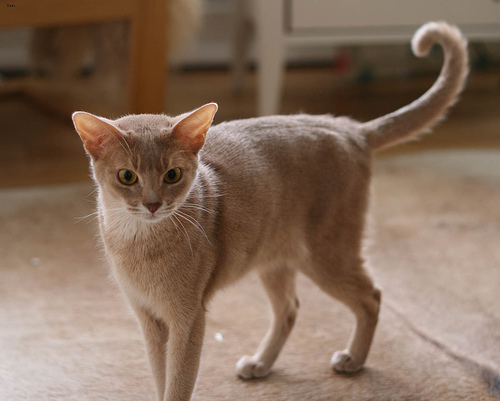

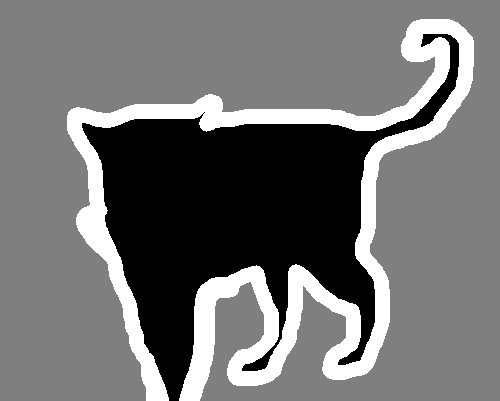

In [3]:
from IPython.display import Image, display
import PIL
from PIL import ImageOps
import PIL.Image as pilimg

imgno = 20

display(Image(filename=input_img_paths[imgno]))
img = PIL.ImageOps.autocontrast(pilimg.open(target_img_paths[imgno]))

display(img)

# Data Preporcessing

In [4]:
import numpy as np
from tensorflow import keras
 

In [5]:
class OxfordPets(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
    
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i: i+self.batch_size]
        batch_target_img_paths = self.target_img_paths[i: i+self.batch_size]
        
        x = np.zeros((self.batch_size,) + self.img_size + (3, ), dtype = 'float32')
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size = self.img_size)
            x[j] = img
            
        y = np.zeros((self.batch_size,) + self.img_size + (1, ), dtype = 'uint8') # color가 아니라 grayscale이므로 1
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size = self.img_size, color_mode = 'grayscale')
            y[j] = np.expand_dims(img, 2)
            y[j] -= 1 # label이 123 으로 되어있는데 이걸 012 로 맞춰주기 위함\

        return x, y
    
        

In [6]:
import random

val_samples = 1000
random.Random(88).shuffle(input_img_paths)
random.Random(88).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_gen = OxfordPets(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

# Create Model 

In [7]:
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    
    x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    previous_block_activation = x # residual
    
    for filters in [64, 128, 256]:# 3 depth를 가지는 layer
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(filters, 3, padding='same')(x)  # separable의 구조적 이점이 있음
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(filters, 3, padding='same')(x)  # separable의 구조적 이점이 있음
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
        residual = layers.Conv2D(filters, 1, strides=2, padding='same')(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x
        
    for filters in [256, 128, 64, 32]:  # Upsampling
        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters, 3, padding='same')(x)  # separable의 구조적 이점이 있음
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters, 3, padding='same')(x)  # separable의 구조적 이점이 있음
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x) # Upsampling

        # residual 을 upsampling할 때도 사용할 수 있도록
        residual = layers.UpSampling2D(2)(previous_block_activation) 
        residual = layers.Conv2D(filters, 1, padding='same')(residual)
        x = layers.add([x, residual])
        previous_block_activation = x

    outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

    model = keras.Model(inputs, outputs)
    return model
    
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Train model

In [10]:
model.compile(optimizer = 'rmsprop', loss='sparse_categorical_crossentropy')

callbacks = [keras.callbacks.ModelCheckpoint('oxford_segmentation.h5', save_best_only=True)]

epochs = 20

model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/20
199/199 [==============================] - 516s 3s/step - loss: 0.6878 - val_loss: 3.0537
Epoch 2/20


/home/r320ws/anaconda3/envs/MLenv/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


199/199 [==============================] - 520s 3s/step - loss: 0.4826 - val_loss: 1.1484
Epoch 3/20
199/199 [==============================] - 530s 3s/step - loss: 0.4165 - val_loss: 0.4132
Epoch 4/20
199/199 [==============================] - 523s 3s/step - loss: 0.3740 - val_loss: 0.4622
Epoch 5/20
199/199 [==============================] - 521s 3s/step - loss: 0.3429 - val_loss: 0.4050
Epoch 6/20
199/199 [==============================] - 521s 3s/step - loss: 0.3143 - val_loss: 0.3953
Epoch 7/20
199/199 [==============================] - 523s 3s/step - loss: 0.2917 - val_loss: 0.3784
Epoch 8/20
199/199 [==============================] - 527s 3s/step - loss: 0.2716 - val_loss: 0.3908
Epoch 9/20
199/199 [==============================] - 521s 3s/step - loss: 0.2549 - val_loss: 0.3915
Epoch 10/20
199/199 [==============================] - 520s 3s/step - loss: 0.2401 - val_loss: 0.3754
Epoch 11/20
199/199 [==============================] - 521s 3s/step - loss: 0.2265 - val_loss: 0.4472

# Inference

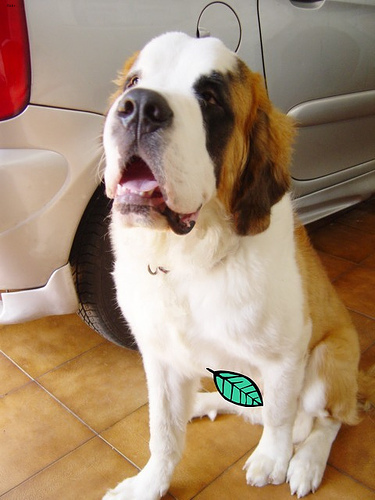

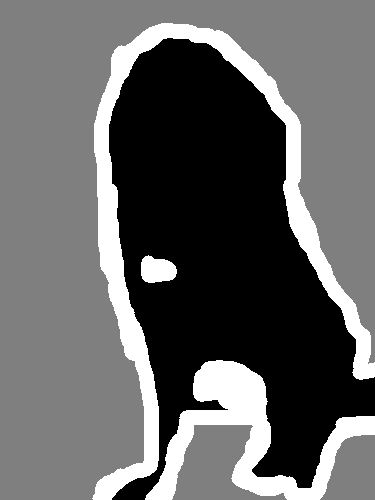

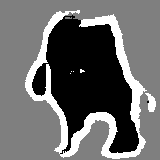

In [12]:
val_preds = model.predict(val_gen)

def display_mask(i):
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

i = 23

display(Image(filename=val_input_img_paths[i]))
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)
display_mask(i)

In [13]:
import time

t1 = time.perf_counter()
model.predict(val_gen)
print(f"timelaps: {time.perf_counter()-t1}")

timelaps: 18.199099448000197
